# L2: Build Customized RAG

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

In [18]:
import os
import warnings
from helper import load_env

warnings.filterwarnings('ignore')
load_env()

In [19]:
from haystack import Pipeline
from haystack.utils.auth import Secret
from haystack.components.builders import PromptBuilder
from haystack.components.converters import HTMLToDocument
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.generators import OpenAIGenerator
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore

from haystack_integrations.components.embedders.cohere import CohereDocumentEmbedder, CohereTextEmbedder

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>

- Fetch Contents from URLs with [`LinkContentFetcher`](https://docs.haystack.deepset.ai/docs/linkcontentfetcher?utm_campaign=developer-relations&utm_source=dlai)
- Convert them to Documents with [`HTMLToDocument`](https://docs.haystack.deepset.ai/docs/htmltodocument?utm_campaign=developer-relations&utm_source=dlai)
- Create embeddings for them with [`CohereDocumentEmbedder`](https://docs.haystack.deepset.ai/docs/coheredocumentembedder?utm_campaign=developer-relations&utm_source=dlai)
- Write them to an [`InMemoryDocumentStore`](https://docs.haystack.deepset.ai/docs/inmemorydocumentstore?utm_campaign=developer-relations&utm_source=dlai)

> ℹ️ Model providers may have outages. If you encounter issues creating embeddings or generating responses, feel free to consider any of the other [Embedder](https://docs.haystack.deepset.ai/docs/embedders?utm_campaign=developer-relations&utm_source=dlai) or [Generator](https://docs.haystack.deepset.ai/docs/generators?utm_campaign=developer-relations&utm_source=dlai) options. For this lesson, we recomment Cohere embedders, or small [Sentence Transformers](https://docs.haystack.deepset.ai/docs/sentencetransformersdocumentembedder?utm_campaign=developer-relations&utm_source=dlai) embedders.

## Indexing Documents


In [20]:
document_store = InMemoryDocumentStore()

fetcher = LinkContentFetcher()
converter = HTMLToDocument()
embedder = CohereDocumentEmbedder(model="embed-english-v3.0", api_base_url=os.getenv("CO_API_URL"))
writer = DocumentWriter(document_store=document_store)

indexing = Pipeline()
indexing.add_component("fetcher", fetcher)
indexing.add_component("converter", converter)
indexing.add_component("embedder", embedder)
indexing.add_component("writer", writer)

indexing.connect("fetcher.streams", "converter.sources")
indexing.connect("converter", "embedder")
indexing.connect("embedder", "writer")

🚅 Components
  - fetcher: LinkContentFetcher
  - converter: HTMLToDocument
  - embedder: CohereDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> embedder.documents (List[Document])
  - embedder.documents -> writer.documents (List[Document])

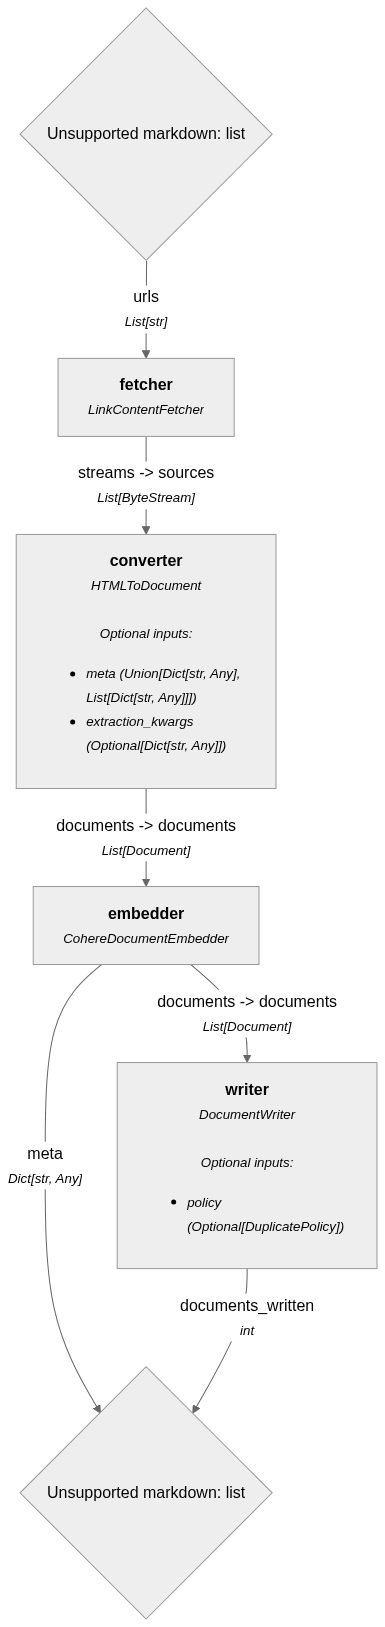

In [21]:
indexing.show()

In [25]:
# # This removes all documents from the store
# document_store.delete_documents()

In [26]:
indexing.run(
    {
        "fetcher": {
            "urls": [
                "https://haystack.deepset.ai/integrations/cohere",
                "https://haystack.deepset.ai/integrations/anthropic",
                "https://haystack.deepset.ai/integrations/jina",
                "https://haystack.deepset.ai/integrations/nvidia",
                "https://haystack.deepset.ai/integrations/azure",
                "https://haystack.deepset.ai/integrations/chroma-documentstore",
                "https://haystack.deepset.ai/integrations/deepeval",
                "https://haystack.deepset.ai/integrations/elevenlabs",
                "https://haystack.deepset.ai/integrations/elasticsearch-document-store",
                "https://haystack.deepset.ai/integrations/google-ai",
                "https://haystack.deepset.ai/integrations/github",
                "https://haystack.deepset.ai/integrations/google-genai",
                "https://haystack.deepset.ai/integrations/google-vertex-ai",
                "https://haystack.deepset.ai/integrations/huggingface",
                "https://haystack.deepset.ai/integrations/llama_cpp",
                "https://haystack.deepset.ai/integrations/milvus-document-store",
                "https://haystack.deepset.ai/integrations/mistral",
                "https://haystack.deepset.ai/integrations/neo4j-document-store",
                "https://haystack.deepset.ai/integrations/ollama",
                "https://haystack.deepset.ai/integrations/pinecone-document-store",
                "https://haystack.deepset.ai/integrations/qdrant-document-store",
                "https://haystack.deepset.ai/integrations/snowflake",
                "https://haystack.deepset.ai/integrations/weaviate-document-store",
                "https://haystack.deepset.ai/integrations/weights-and-bias-tracer"
            ]
        }
    }
)

Calculating embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.63it/s]


{'embedder': {'meta': ApiMeta(api_version=ApiMetaApiVersion(version='', is_deprecated=True, is_experimental=None), billed_units=ApiMetaBilledUnits(input_tokens=11804.0, output_tokens=None, search_units=None, classifications=None), tokens=None, warnings=['Please set an API version, for more information please refer to https://docs.cohere.com/versioning-reference', 'Version is deprecated, for more information please refer to https://docs.cohere.com/versioning-reference'])},
 'writer': {'documents_written': 24}}

In [27]:
document_store.filter_documents()[0]

Document(id=da82644777144c9b29f2d504f2cbd51562b3d48b34f4097499f49c2618b7c44b, content: 'Integration: Cohere
Use Cohere models with Haystack
Table of Contents
Overview
You can use Cohere Mo...', meta: {'content_type': 'text/html', 'url': 'https://haystack.deepset.ai/integrations/cohere'}, embedding: vector of size 1024)

## Retrieval Augmented Generation
### 1. Decide on the Prompt
Augment the prompt with the contents of these documents using the [`PromptBuilder`](https://docs.haystack.deepset.ai/docs/promptbuilder?utm_campaign=developer-relations&utm_source=dlai). This component uses Jinja templating [[+]](https://jinja.palletsprojects.com/en/3.1.x/)

In [28]:
prompt = """
Answer the question based on the provided context.
Context:
{% for doc in documents %}
   {{ doc.content }} 
{% endfor %}
Question: {{ query }}
"""

### 2. Build the Pipeline

In [29]:
query_embedder = CohereTextEmbedder(model="embed-english-v3.0", api_base_url=os.getenv("CO_API_URL"))
retriever = InMemoryEmbeddingRetriever(document_store=document_store)
prompt_builder = PromptBuilder(template=prompt)
generator = OpenAIGenerator()

rag = Pipeline()
rag.add_component("query_embedder", query_embedder)
rag.add_component("retriever", retriever)
rag.add_component("prompt", prompt_builder)
rag.add_component("generator", generator)

rag.connect("query_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever.documents", "prompt.documents")
rag.connect("prompt", "generator")

🚅 Components
  - query_embedder: CohereTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt: PromptBuilder
  - generator: OpenAIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt.documents (List[Document])
  - prompt.prompt -> generator.prompt (str)

> Note: It is possible to use a different model for the generator. For example, if you'd like to use Llama-3, update the code above to:

```
generator = OpenAIGenerator(api_key=Secret.from_env_var("TOGETHER_AI_API"),
                            model="meta-llama/Llama-3-70b-chat-hf",
                            api_base_url="https://api.together.xyz/v1")
```

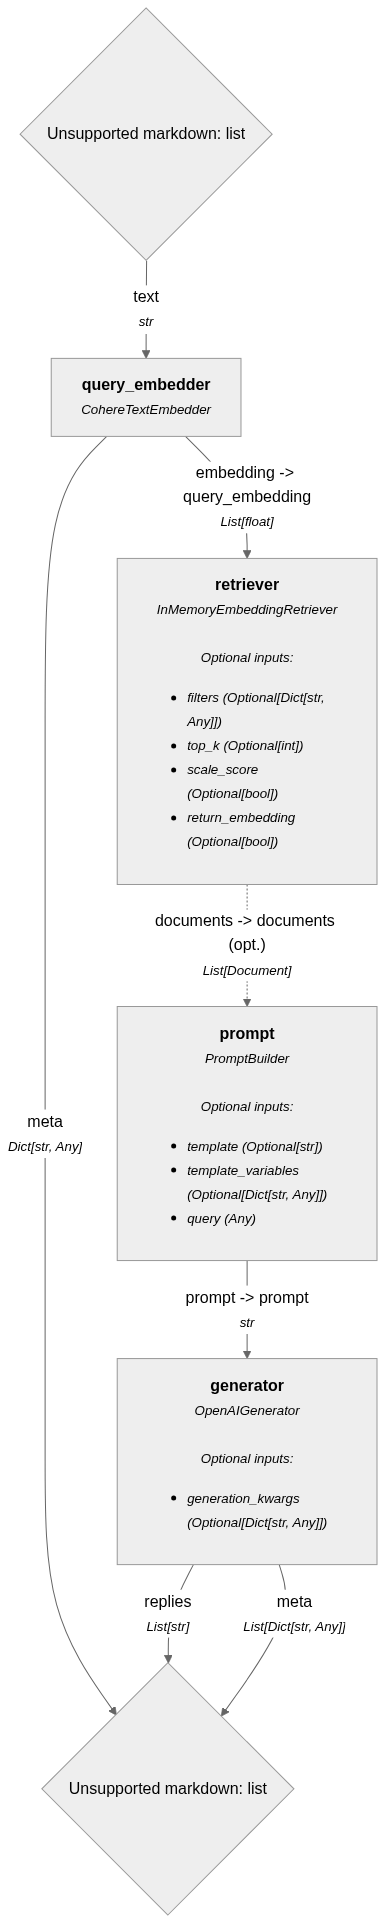

In [30]:
rag.show()

In [31]:
question = "How can I use Cohere with Haystack?"

result = rag.run(
    {
        "query_embedder": {"text": question},
        "retriever": {"top_k": 1},
        "prompt": {"query": question},
    }
)

print(result["generator"]["replies"][0])

You can use Cohere with Haystack by installing the necessary package using pip:
```bash
pip install cohere-haystack
```
After installation, you can utilize Cohere models in your Haystack pipelines for tasks such as generating embeddings for textual or image-based documents, using generative models for question answering, or ranking documents based on semantic relevance to a query. The integration with Cohere allows you to enhance the capabilities of your information retrieval and natural language processing workflows within the Haystack framework.


### 3. Customize The Behaviour

In [32]:
prompt = """
You will be provided some context, followed by the URL that this context comes from.
Answer the question based on the context, and reference the URL from which your answer is generated.
Your answer should be in {{ language }}.
Context:
{% for doc in documents %}
   {{ doc.content }} 
   URL: {{ doc.meta['url']}}
{% endfor %}
Question: {{ query }}
Answer:
"""

In [33]:
query_embedder = CohereTextEmbedder(model="embed-english-v3.0", api_base_url=os.getenv("CO_API_URL"))
retriever = InMemoryEmbeddingRetriever(document_store=document_store)
prompt_builder = PromptBuilder(template=prompt)
generator = OpenAIGenerator(model="gpt-3.5-turbo")

rag = Pipeline()
rag.add_component("query_embedder", query_embedder)
rag.add_component("retriever", retriever)
rag.add_component("prompt", prompt_builder)
rag.add_component("generator", generator)

rag.connect("query_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever.documents", "prompt.documents")
rag.connect("prompt", "generator")

🚅 Components
  - query_embedder: CohereTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt: PromptBuilder
  - generator: OpenAIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt.documents (List[Document])
  - prompt.prompt -> generator.prompt (str)

In [34]:
question = "How can I use Cohere with Haystack?"

result = rag.run(
    {
        "query_embedder": {"text": question},
        "retriever": {"top_k": 1},
        "prompt": {"query": question, "language": "French"},
    }
)

print(result["generator"]["replies"][0])

Vous pouvez utiliser les modèles Cohere dans vos pipelines Haystack avec les générateurs et les intégrateurs. Vous pouvez créer des embeddings sémantiques pour des documents textuels en utilisant CohereDocumentEmbedder dans votre pipeline d'indexation. Pour les documents basés sur des images, utilisez CohereDocumentImageEmbedder. De plus, vous pouvez également utiliser des modèles génératifs, des modèles de chat et des modèles de classement de Cohere avec Haystack.
URL: https://haystack.deepset.ai/integrations/cohere
